#  赛题十二 —— 论文复现自验报告

赛题内容：利用 MindQuantum 实现量子生成对抗模型

论文题目：Faking and Discriminating the Navigation Data of a Micro Aerial Vehicle Using Quantum Generative Adversarial Networks
 
复现要求：利用 MindQuantum 实现文章的 QGAN，复现 fig7。

## 赛题介绍

网络物理系统（CPSs）涵盖监测和控制嵌入式计算、网络资源的物理过程。控制器和探测器的信号通过无线通信等方式进行交换。这种架构的优点是具有灵活性和相对较低的部署成本。然而，网络物理攻击的问题必须解决。当物理网络系统由微型飞行器、无人机和蜂群等颠覆性技术组成时，这个问题的解决非常具有挑战性。

今天的网络安全解决方案，从深入的防御技术（如防火墙）到入侵检测和加密技术，旨在防止物理网络系统被破坏。然而，现实中也曾发生过几个关于攻击和破坏物理网络系统的事件。例如，破坏伊朗原子能计划的 Stuxnet 蠕虫事件和最近发生在沙特阿拉伯的干扰胡塞武装直升机事件。网络物理系统
保护解决方案必须管理和对敌方行动进行控制。网络物理系统的保护必须能够对敌对行为进行管控。保护系统需要掌握对手的思维方式，预测其意图并 减轻其行动的影响。

本论文探讨了如何使用量子生成对抗网络 （QGAN）来解决微型无人机领域的网络物理安全问题。论文提出了一个具体的 QGAN 设计，以产生虚假的微型无人机导航数据。最初，对抗方完全不知道网络物理系统的动态。从对手的角度出发，是该方法的优势。另外，还提出了一种可以用于区分真实和虚假的微型无人机导航数据的方案。

QGAN 系统包括两部分：生成器和鉴别器。生成器用于生成虚假的导航数据，而鉴别器用于鉴别输入的导航数据是真实的，还是虚假的。
方案先对鉴别器进行训练，使其能够鉴别出真实数据和随机数据。之后，再对生成器进行训练，令其产生的数据，以尽可能高的概率通过鉴别器的监测。

在方案中，采用概率振幅编码将真实的连续性数据（导航的坐标信息）编码成量子态，用以训练鉴别器。
下面为一组真实的导航数据，每一行的第一列为时间戳，第二、三、四列分别为 $x, y, z$ 的坐标信息。

In [1]:
import numpy as np
data = np.loadtxt('./src/realdata'+'0'+'.txt')
print(data[:5])

[[ 6.90906463e+00 -8.37690800e-02  3.39405660e-01  1.83541000e-03]
 [ 7.07760779e+00 -8.37690800e-02  3.39405660e-01  1.83541000e-03]
 [ 7.22510129e+00 -8.37690800e-02  3.39405660e-01  1.83541000e-03]
 [ 7.37562029e+00  1.09504000e-03 -1.50231700e-02  1.23634100e-02]
 [ 7.52478847e+00  1.09504000e-03 -1.50231700e-02  1.23634100e-02]]


忽略时间戳，而仅将每行的坐标信息保留，并缀连在一起，采用振幅编码线路，将一定长度的信息编码为量子态。比如，对于两个量子比特的系统，qubit_num=2，可以编码 $2^{\mathrm{qubit\_num}}=2^2=4$ 个经典信息。其他尺寸的系统类似可推。 

In [2]:
qubit_num = 2
value_len = 2 ** qubit_num
sampled_data = data[:,1:4] # omit the timestamp
sampled_data = sampled_data.reshape(len(sampled_data)*3)
real_value = sampled_data[0:min(value_len, len(sampled_data))]
print(real_value)

[-0.08376908  0.33940566  0.00183541 -0.08376908]


编码线路为和参数为：

[0.47048127495501724, 3.6255428314452973, -3.0977789605155976]


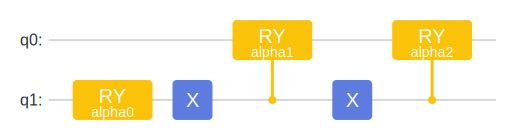

In [4]:
from mindquantum import *
encoder, parameterResolver = amplitude_encoder(real_value, qubit_num)
print(parameterResolver.params_value)
encoder.svg()

初始的虚假数据设置为对应长度的随机数，鉴别器的作用就是经过训练，准确识别出真实数据和虚假数据。鉴别器的构成为多层的基础线路，这里，我们的鉴别器采用了 10 层基础线路的结构。其中，基础线路为：

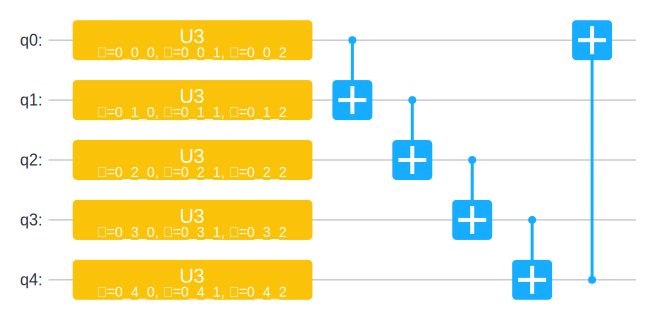

In [6]:
def QLayer(qubit_num=2, prefix='0'):
    circ_ = Circuit()
    for qubit in range(qubit_num):
        circ_ += U3(f'{qubit}_0', f'{qubit}_1', f'{qubit}_2').on(qubit)
    for qubit in range(qubit_num-1):
        circ_ += X.on(qubit+1, qubit)
    circ_ += X.on(0, qubit_num-1)
    circ_ = add_prefix(circ_, prefix)
    return circ_

def Discriminator(qubit_num=2, layer_num=4):
    circ_ = Circuit()
    for _ in range(layer_num):
        circ_ += QLayer(qubit_num=qubit_num, prefix=f'{_}')
    return circ_

qlayer = QLayer(qubit_num=5)
qlayer.svg()

对于双比特系统，基础线路为：

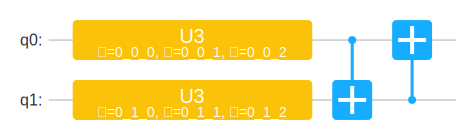

In [7]:
qlayer = QLayer(qubit_num=2)
qlayer.svg()

鉴别器对数据的鉴别标准是第 0 个比特 `Z0` 的期望值。当期望值为 +1 时，鉴定为真，当期望值为 -1 时，鉴定为假。
`encoder` 线路不参与训练，其参数由待编码的经典数据决定，而 `ansatz` 线路作为鉴别器的主体，其参数参与训练。

In [8]:
def build_grad_ops(qubit_num=2, layer_num=4):
    encoder = Generator(qubit_num)
    encoder.no_grad()
    ansatz = Discriminator(qubit_num, layer_num)
    circ = encoder.as_encoder() + ansatz.as_ansatz()
    sim = Simulator('mqvector', qubit_num)
    ham = Hamiltonian(QubitOperator('Z0'))
    grad_ops = sim.get_expectation_with_grad(ham, circ)
    return grad_ops

损失函数为目标期望值与当前鉴别器输出期望值的差值的绝对值。

In [10]:
from mindspore.nn import LossBase
class MyLoss(LossBase):
    def __init__(self, reduction='mean'):
        super(MyLoss, self).__init__(reduction)
        self.abs = ops.Abs()

    def construct(self, logits, label):
        out =self.abs(logits - label)
        return self.get_loss(out)

优化器选择 `Adam` 且学习率设为 0.05

In [ ]:
qubit_num = 2
sample_num = 6
layer_num = 10
real_paras = get_real_paras(qubit_num=qubit_num, sample_num=sample_num)
fake_paras = get_fake_paras(qubit_num=qubit_num, sample_num=sample_num)

QuantumNet = MQLayer(build_grad_ops(qubit_num=qubit_num, layer_num=layer_num))
loss = MyLoss()
net_with_criterion = MyWithLossCell(QuantumNet, loss)
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.05)
net = TrainOneStepCell(net_with_criterion, opti)

接下来轮流对真实数据和虚假数据进行训练一定回合。并分别绘出随着训练次数增加，鉴别器对真实数据和虚假数据判断为 `真` 的概率变化情况。同时将鉴别器最终参数进行保存，用以后面辅助对生成器的训练。

In [ ]:
epochs = 20
real_pros = []
fake_pros = []

for _ in range(epochs):
    real_pro = []
    fake_pro = []
    for i in range(sample_num):
        real_loss = net(Tensor([real_paras[i]]), Tensor([1.]))
        fake_loss = net(Tensor([fake_paras[2]]), Tensor([-1.]))
        real_pro.append ((QuantumNet(Tensor([real_paras[i]]))[0,0].asnumpy()+1)/2)
        fake_pro.append ((QuantumNet(Tensor([fake_paras[2]]))[0,0].asnumpy()+1)/2)
    real_pros.append(np.mean(real_pro))
    fake_pros.append(np.mean(fake_pro))

plt.figure()
plt.plot(real_pros, label='Real_True_pro', linestyle='-') # 画出训练过程中，验证集分类准确度的变化情况
plt.plot(fake_pros, label='Fake_True_pro', linestyle='-')
plt.title('True_pro of Discirminator', fontsize=20)
plt.legend() 
plt.xlabel('Steps', fontsize=20)
plt.ylabel('True_pro', fontsize=20)
plt.savefig('./src/2_qubit_Discriminator.png')
plt.show()

np.save(f'./src/2_qubit_Discriminator_paras.npy', QuantumNet.weight.asnumpy())

下图就是对于双比特系统，鉴别器对真实数据和虚假数据判断为 `真` 的概率随训练次数的变化情况。(该结果可通过执行文件 `2_qubit.ipynb` 中的 `程序 0` 得到) 可见，训练取得了很好的效果。

![2_qubit_Discriminator_png](./src/2_qubit_Discriminator.png)。

## 生成器的训练

上面提到了，生成器采用振幅编码线路，且其输出的量子态作为鉴别器的输入。鉴别器直接采用前面的结构和参数。生成器的目标就是通过训练，使其的输出能够以尽可能大的概率被鉴别器鉴定为 `真`。

In [ ]:
discriminator_paras = np.load(f'./src/{qubit_num}_qubit_Discriminator_paras.npy', allow_pickle=True) 

QuantumNet = MQLayer(build_grad_ops(qubit_num=qubit_num, layer_num=layer_num))
loss = MyLoss()
net_with_criterion = MyWithLossCell(QuantumNet, loss)
opti = Adam(QuantumNet.trainable_params(), learning_rate=0.05)     # 需要优化的是Quantumnet中可训练的参数，学习率设为0.5
net = TrainOneStepCell(net_with_criterion, opti)

steps = 20
fake_pros = []

for _ in range(steps):
    fake_loss = net(Tensor([discriminator_paras]), Tensor([1.]))
    fake_pros.append((QuantumNet(Tensor([discriminator_paras]))[0,0].asnumpy()+1)/2)

plt.figure()
plt.plot(fake_pros, label='Fake_True_pro', linestyle='-')
plt.title('Fake_True_pro of Generator', fontsize=20)
plt.legend() 
plt.xlabel('Steps', fontsize=20)
plt.ylabel('Fake_True_pro', fontsize=20)
plt.savefig('./src/2_qubi_Generator.png')
plt.show()

下图就是对于双比特系统，鉴别器对真实数据和虚假数据判断为 `真` 的概率随训练次数的变化情况。可见，训练取得了很好的效果。(该结果可通过执行文件 `2_qubit.ipynb` 中的 `程序 1` 得到)

![2_qubit_Generator_png](./src/2_qubi_Generator.png)。

以上以双比特系统为例进行了介绍。下面是采用相同方法，对 2、3、4、5 比特系统鉴别器和生成器训练的结果。

(该结果可通过执行文件 `main.ipynb` 中的 `程序 0`  和 `主程序 1` 得到) 该结果和原论文结论一致。

![Disciminator_Real_True_probs](./src/Disciminator_Real_True_probs.png)
![Discriminator_training_times](./src/Discriminator_training_times.png)

![Generator_Fake_True_probs](./src/Generator_Fake_True_probs.png)
![Generatorr_training_times](./src/Generatorr_training_times.png)

In [13]:
from mindquantum.utils.show_info import InfoTable

InfoTable('mindquantum', 'mindspore')

Software,Version
mindquantum,0.9.0
mindspore,2.1.0
System,Info
Python,3.9.13
OS,Linux x86_64
Memory,16.62 GB
CPU Max Thread,16
Date,Tue Oct 17 20:44:43 2023
